# ORF recognition by CNN

Use variable number of bases between START and STOP. Thus, ncRNA will have its STOP out-of-frame or too close to the START, and pcRNA will have its STOP in-frame and far from the START.

In [39]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-08-03 23:54:26 UTC'

In [40]:
PC_SEQUENCES=10000   # how many protein-coding sequences
NC_SEQUENCES=10000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=32            # how long is each sequence
CDS_LEN=16            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.3
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [41]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [42]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [43]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 26 trials to reach 10 per class.
It took 47339 trials to reach 11000 per class.
Use 11000 PC seqs
Use 11000 NC seqs


In [44]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 32.0
Average ORF length: 19.702636363636362
NC seqs
Average RNA length: 32.0
Average ORF length: 2.889818181818182


In [45]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [46]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [47]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (32, 4)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 32, 16)            208       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 32, 16)            784       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 16, 16)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 16, 16)            784       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 16, 16)            784       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 8, 16)             0         
_________________________________________________________________
flatten_9 (Flatten)     

In [48]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/100
417/417 [==============================] - 4s 6ms/step - loss: 0.6736 - accuracy: 0.5984 - val_loss: 0.5524 - val_accuracy: 0.7323
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/100
417/417 [==============================] - 2s 5ms/step - loss: 0.5463 - accuracy: 0.7427 - val_loss: 0.4837 - val_accuracy: 0.7696
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/100
417/417 [==============================] - 2s 5ms/step - loss: 0.4752 - accuracy: 0.7784 - val_loss: 0.4317 - val_accuracy: 0.7989
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/100
417/417 [==============================] - 2s 5ms/step - loss: 0.4272 - accuracy: 0.8041 - val_loss: 0.3961 - val_accuracy: 0.8239
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/100
417/417 [==============================] - 2s 5ms/step - loss: 0.3905 - accuracy: 0.8292 - val_loss: 0.3779 - val_accuracy: 0.8344
INFO:tensorflow:Assets written to: Be

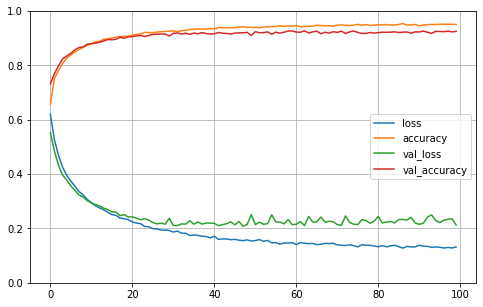

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/100
417/417 [==============================] - 3s 6ms/step - loss: 0.6753 - accuracy: 0.5721 - val_loss: 0.5501 - val_accuracy: 0.7266
Epoch 2/100
417/417 [==============================] - 2s 4ms/step - loss: 0.5432 - accuracy: 0.7293 - val_loss: 0.4726 - val_accuracy: 0.7740
Epoch 3/100
417/417 [==============================] - 2s 5ms/step - loss: 0.4829 - accuracy: 0.7734 - val_loss: 0.4325 - val_accuracy: 0.7947
Epoch 4/100
417/417 [==============================] - 2s 4ms/step - loss: 0.4388 - accuracy: 0.7940 - val_loss: 0.4162 - val_accuracy: 0.8095
Epoch 5/100
417/417 [==============================] - 2s 5ms/step - loss: 0.4107 - accuracy: 0.8090 - val_loss: 0.3840 - val_accuracy: 0.8197
Epoch 6/100
417/417 [==============================] - 2s 4ms/step - loss: 0.3943 - accuracy: 0.8148 - val_loss: 0.3621 - val_accuracy: 0.8314
Epoch 7/100
417/417 [==============================] - 2s 4ms/step - loss: 0.3689 - accuracy: 0.8278 -

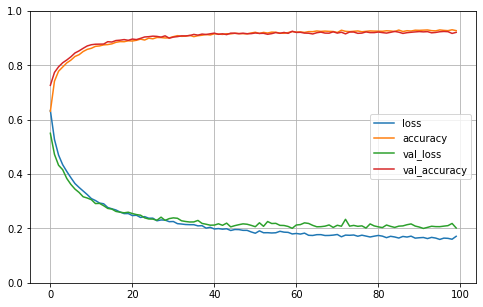

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/100
417/417 [==============================] - 3s 6ms/step - loss: 0.6701 - accuracy: 0.5909 - val_loss: 0.5481 - val_accuracy: 0.7441
Epoch 2/100
417/417 [==============================] - 2s 5ms/step - loss: 0.5355 - accuracy: 0.7426 - val_loss: 0.4911 - val_accuracy: 0.7658
Epoch 3/100
417/417 [==============================] - 2s 5ms/step - loss: 0.4774 - accuracy: 0.7718 - val_loss: 0.4489 - val_accuracy: 0.7900
Epoch 4/100
417/417 [==============================] - 2s 5ms/step - loss: 0.4335 - accuracy: 0.7974 - val_loss: 0.4268 - val_accuracy: 0.7990
Epoch 5/100
417/417 [==============================] - 2s 5ms/step - loss: 0.3926 - accuracy: 0.8214 - val_loss: 0.3947 - val_accuracy: 0.8222
Epoch 6/100
417/417 [==============================] - 2s 5ms/step - loss: 0.3754 - accuracy: 0.8320 - val_loss: 0.3705 - val_accuracy: 0.8327
Epoch 7/100
417/417 [==============================] - 2s 5ms/step - loss: 0.3457 - accuracy: 0.8487 -

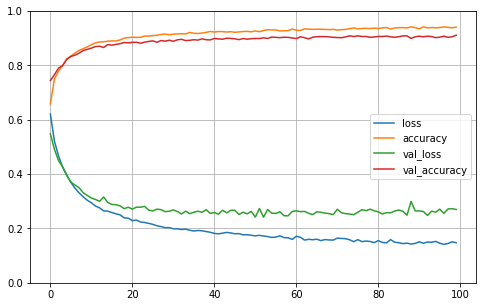

In [49]:
do_cross_validation(X,y)

In [50]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 91.10%


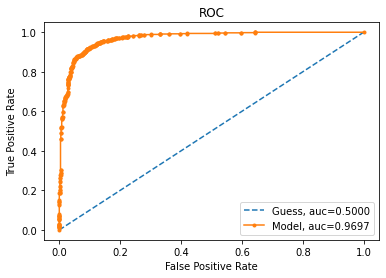

AUC: 96.97%


In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [52]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-08-04 00:06:42 UTC'